## PART 2 of the Plassticc challenge homework: implement classification and clustring on the feature space you created in the previous homework

## this homework is split into 2. In the first part, due by Thursday 9th at noon, you will engineer features from time series. In the second half, due Thursday 16th at noon, you will use those features to find structure in the feature space (unsupervised learning, i.e. clustering) and classify by example with CART (supervised learning with random forest or gradient boosted tree models)

# Classifying astrophysical transients from photometry

## OVERVIEW

The PLAsTiCC challenge is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in the light emission in 6 different bands. The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023). 

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good riend Gautham Narayan in fact!) to get started and ingest and preprocess the PLASTiCC challenge data. However, this is written with a class (object oriented) and we have not talked about this syntax in class. If you are not familiar with classes do not worry about it (but you should learn them!). Also I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and run 2 models on these feautes: a cluster model, and a classification tree. 

To limit confusion I removed the first part of the notebook. You can find it in https://github.com/fedhere/MLTSA_FBianco/tree/master/HW5 in the solution notebook


In [1]:
import pandas as pd
import numpy as np
import sklearn


import pylab as pl
%pylab inline

plt = pl

Populating the interactive namespace from numpy and matplotlib


In [2]:
allfeatures = pd.read_csv('https://raw.githubusercontent.com/JinbiaoJi/MLTSA_JJi/master/HW5/allfeatures.csv',index_col=0)

In [3]:
allfeatures.head()

,"(0, 'mean')","(0, 'std')","(0, 'moment2')","(0, 'moment3')","(0, 'max')","(0, 'min')","(0, 'median')","(0, 'slopes')","(0, 'intercepts')","(0, 'll1')",...,"(5, 'slopes')","(5, 'intercepts')","(5, 'll1')","(5, 'll2')","(5, 'll3')",decl,ddf,hostgal_photoz,hostgal_photoz_err,target
0,-3.254554,83.944735,6934.865833,72665.792850,125.182808,-116.913223,-0.080537,0.005676,-0.175947,-88.218652,...,0.021319,-0.596932,-77.386461,-76.917754,-1.0,-61.943836,1,0.0000,0.0000,92
1,-2.720398,7.113509,49.879128,89.634243,14.509829,-14.735178,-0.052914,-0.041433,1.429423,-49.801325,...,-0.037903,1.042343,-65.424297,-65.167686,-1.0,-27.784405,1,1.6267,0.2552,88
2,-0.048080,1.828872,3.298318,2.093148,5.942166,-3.459960,0.039463,-0.001798,0.063840,-101.606902,...,0.019612,-0.490299,-67.853917,-66.518080,1.0,-6.579593,1,0.2262,0.0157,42
3,1.797523,4.374445,18.869993,162.368381,18.014029,-3.874349,-0.169349,-0.013089,0.464675,-100.184915,...,-0.002816,0.076043,-77.536999,-64.783463,-1.0,-45.586655,1,0.2813,1.1523,90
4,0.660948,2.360084,5.481586,-4.160853,5.330927,-6.804703,-0.033864,0.017117,-0.530614,-84.969286,...,0.015555,-0.435534,-76.666778,-76.526495,1.0,-63.823658,1,0.2415,0.0176,90


### make sure you deal with missing data

In [4]:
# -- personally I choose to drop the feature 
allfeatures = allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# PART II: I already guided you  through some of these tasks, but sort of "blindly". Start from here for part 2: we will reperform some of the tasks more thoughtfully (and correctly) and you will apply both clustering and classification to the PLASTiCC challenge data

# PART IIA : Preprocessing


## Task II.1: Preprocess your features by scaling them along the feature axis

Scale your training and test sets to remove the correlation: each feature is preprocessed so that it is mean=0 and standard deviation =1 - we will talk about it in class but make sure you deliver in this notebook the scaled features as below. Save the original mean and standard deviation for all features

**Deliverable II.1: the means and standard deviation arrays and the scaled features array**

**NOTE I HAD A MISTAKE IN THE NOTEBOOK LAST WEEK! you want to scale for the full set at once, and save the values of mean and standard deviation of the full set so you can preprocess future observations that are in nither sets the same way**



In [5]:
X = allfeatures.iloc[:,:-1].values
y = allfeatures.iloc[:,-1].values

In [6]:
featuremeans = allfeatures.mean()
featurestd = allfeatures.std()
print("saved means and standard deviation arrays", featuremeans, featurestd)
print("number of observcations {}, features {}, means {}, standard deviations {}".format(
    *X.shape, featuremeans.shape[0], featurestd.shape[0]))

saved means and standard deviation arrays (0, 'mean')           3.927376e+01
(0, 'std')            2.182559e+02
(0, 'moment2')        1.174025e+08
(0, 'moment3')        9.320874e+13
(0, 'max')            5.238822e+02
(0, 'min')           -2.477077e+02
(0, 'median')        -7.309789e-02
(0, 'slopes')         3.243197e-04
(0, 'intercepts')     6.374716e-03
(0, 'll1')           -3.385297e+01
(0, 'll2')           -3.234538e+01
(0, 'll3')            8.154944e-03
(1, 'mean')           2.961879e+01
(1, 'std')            1.882913e+02
(1, 'skew')           1.343296e+00
(1, 'moment2')        1.266000e+06
(1, 'moment3')        3.165967e+10
(1, 'max')            3.879990e+02
(1, 'min')           -1.888418e+02
(1, 'median')        -1.581918e-01
(1, 'slopes')        -4.470312e-03
(1, 'intercepts')     2.588712e-02
(1, 'll1')           -2.964366e+01
(1, 'll2')           -2.761543e+01
(1, 'll3')            5.377166e-02
(2, 'mean')           4.293301e+01
(2, 'std')            2.047913e+02
(2, 'skew')  

In [7]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)
print("scaled training data feature mean and standard deviations: ", 
      X_scaled.mean(axis=0), X_scaled.std(axis=0))


scaled training data feature mean and standard deviations:  [ 2.71614196e-18 -3.62152261e-18  1.81076130e-18 -2.71614196e-18
 -2.71614196e-18  1.81076130e-18  1.44860904e-17  6.33766456e-18
  3.62152261e-18  0.00000000e+00  5.79443617e-17  6.51874070e-17
  4.07421293e-18 -2.71614196e-18  0.00000000e+00  6.33766456e-18
  3.62152261e-18 -7.24304522e-18  1.26753291e-17 -1.81076130e-17
 -1.62968517e-17 -5.43228391e-18  0.00000000e+00  5.79443617e-17
 -2.53506583e-17  0.00000000e+00  5.43228391e-18  1.44860904e-17
  0.00000000e+00 -4.52690326e-18 -1.13172582e-18  1.81076130e-18
  1.08645678e-17  8.14842587e-18 -1.35807098e-18  0.00000000e+00
  0.00000000e+00  1.23131769e-16  0.00000000e+00 -5.20593875e-18
 -2.89721809e-17  1.81076130e-18  0.00000000e+00  1.81076130e-18
  1.08645678e-17 -7.24304522e-18 -1.08645678e-17 -3.16883228e-18
  0.00000000e+00 -5.79443617e-17  7.24304522e-18  1.81076130e-18
  3.16883228e-18 -2.89721809e-17  5.43228391e-18  2.71614196e-18
 -5.88497424e-18  5.43228391e-

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "



# Task II.2: You already did this in part I: you do not have to do it again if you are satisfied with what you did, but retun this since you redid the scaling of the features: Visualize a large dimensional feature space to plan the analysis and produce a 2D t-SNE projection of your feature space and visualize it. 
If you are lucky, this will be a pretty plot!
a great model to **Visualize** structure in data is  t-SNE: t-distributed Stocastic Neighbourhood Embedding
It project N-dimensional data on a 2-dimensional surface preserving the N-dimensional distance. If thre is structure in the feature space, it should show. If there is structure in feature space, clustering is a promising technique.


In [8]:
from sklearn.manifold import TSNE

(7848, 2)


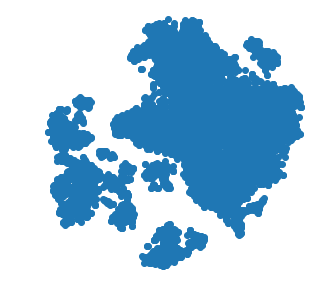

Figure: the 2D projection of the ~83-dimensional feature space we created by extracting features from the time series. The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledianpairwise distances existing in the higher dimensional parameter space. How many clusters can you see in this embedding?A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, this is the only cxase in which you are allowed not to label your axes!


In [9]:
X_embedded = TSNE(n_components=2, random_state=345).fit_transform(X_scaled)
print(X_embedded.shape)
plt.figure(figsize=(5,5))
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.axis('off')
plt.show()
print("Figure: the 2D projection of the ~83-dimensional feature space we created by extracting features from the time series. " + 
      "The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: " + 
      "t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledian" + 
      "pairwise distances existing in the higher dimensional parameter space. " + 
      "How many clusters can you see in this embedding?" + 
      "A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, " + 
      "this is the only cxase in which you are allowed not to label your axes!")


We have to assure that the clusters map to the target variable tho. So I will redo the plot colorcoded by target variable

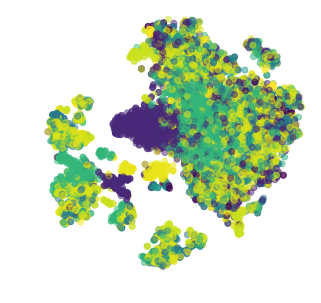

In [10]:
norm_obj= Normalize(vmin=y.min(), vmax=y.max())
len([c for c in plt.cm.RdBu_r(norm_obj(y))]), X_embedded.shape
plt.figure(figsize=(5,5))
plt.axis('off')
plt.scatter(X_embedded[:,0], X_embedded[:,1],  
           color=[c for c in pl.cm.viridis(norm_obj(y))], alpha=0.5);

**Figure 2:** the purity of the sample is not good in the t-SNE projection against the target variable. The colors are mixed in most t-SNE clusters, the highest purity is achieved near the center of the projected feature space. **This is not a particularly promising situation**

Does this map better on other features in the metadata?



**Deliverable II.2: make your version of the plot below, and discuss your own result, which will likely be somewhast different from mine. Do you see any other insightful mapping of the features in the t-SNE projection?**

In [11]:
metadata = pd.read_csv("https://raw.githubusercontent.com/JinbiaoJi/MLTSA_JJi/master/HW5/PLAsTiCC-2018/training_set_metadata.csv")

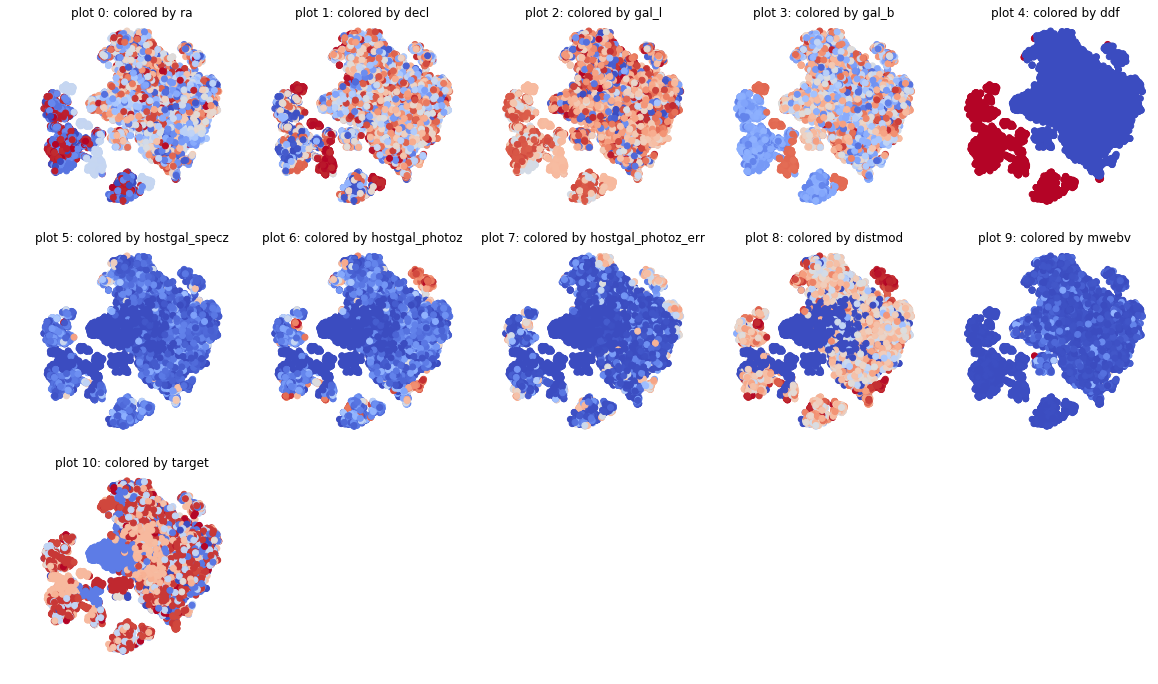

In [12]:
fig = plt.figure(figsize=(20,20))
# note: I am avoiding the first column of metadata which is the object identifier
for i, col in enumerate(metadata.columns[1:]):
    ax = fig.add_subplot(5,5,i+1)
    v = metadata[col].astype(float)
    ax.set_title("plot %d: colored by %s"%(i,col))
    ax.scatter(X_embedded[:,0], X_embedded[:,1],  
               color=[plt.cm.coolwarm(Normalize(vmin=v.min(), vmax=v.max())(c))
                                                         for c in v])
    ax.axis('off')

    #pl.show()

Figure. 3 : the feature space is projected on a 2D plane via t-SNE method, and the points are colorcoded by the value of all metadata: this includes features used in the feature space as well as features that are not used in the feature space. The fueature space t-SNE projection does not map the metadata, except for the survey: **row 1 and column 3** the data includes a DeepDrillingField survey and a regular survey (called wide-fast-deep) which include different observation strategy decisions (data collection strategy). Those are obviously affecting the data features this the clear split of the cluster in row 1 column 3.  (The deep drilling fields are special regions of the sky that would be observed more frequently, a whole bunch of times in one night. So even if an object were the same kind of object the extracted features could be very different!).

Most other features map the t-SNE projection more poorly. 


# PART IIB : Clustering 
## cluster the data using Agglomerative and DBscan. 
    


In [13]:
from sklearn.cluster import AgglomerativeClustering


Here is how I could cluster the data using the Euclidian distance with Agglomeratie Clustering stoopping the algorithm at 3 clusters. The Eucledian distance is the default for this (and most other) clustering algorithms implemented in sklearn. 

- Note: I can use the Eucledian distance **because** I preprocessed the feature space and all features have the same standard deviation!* 

- Note: the AgglemerativeClustering implementation in python allows to specify the number of clusters (I will use 3): the agglomeration will stop there for efficiency, this is not the same as having to specify the number of clusters in k-means, where the result depends on the number of clusters. In agglomerative clustering the following clusters would be segmentations of the first 2. 



elements in cluster 0 5759
elements in cluster 1 1
elements in cluster 2 2088



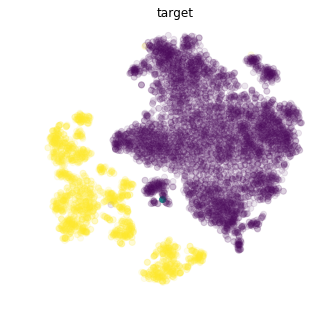

Figure 4: clustering the 83 dimensional feature space based on Agglomerateive Clustering algorithm with Eucledian distance into 3 clusters. There are 2 clusters of several observations, mapping excellently to the t-SNE projectionOne cluster of one indicates the presence of an outlier


In [14]:
clustering = AgglomerativeClustering(n_clusters=3).fit(X_scaled)

for j in range(3):
    print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
print()
pl.figure(figsize=(5,5))
pl.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in clustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
pl.axis('off')
pl.show()
print("Figure 4: clustering the 83 dimensional feature space based on " + 
      "Agglomerateive Clustering algorithm with Eucledian distance into 3 clusters. " + 
     "There are 2 clusters of several observations, mapping excellently to the t-SNE projection" + 
     "One cluster of one indicates the presence of an outlier")



## TASK II.3:  Use AgglomerativeClustering in sklearn allows to select the number of cluster, run AgglomearativeCLustering with 2,3,4,5,6 clusters with Eucledian distance. Comment on the results.

**Deliverable II.3: plot the clusters obtained with AgglomerativeClustering with n_custer 2...6 and Eucledian distance, and comment on the result (mapping on t-SNE, outliers, consistence between the results obtained with different number of clusters)**


elements in cluster 0 7847
elements in cluster 1 1



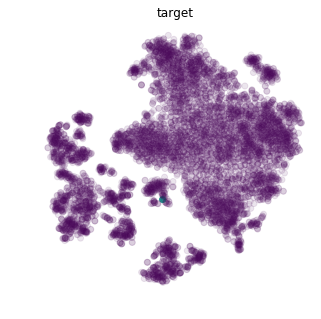

elements in cluster 0 5759
elements in cluster 1 1
elements in cluster 2 2088



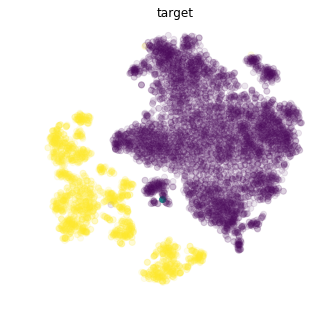

elements in cluster 0 5758
elements in cluster 1 1
elements in cluster 2 2088
elements in cluster 3 1



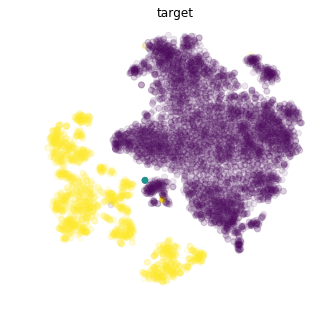

elements in cluster 0 4428
elements in cluster 1 1330
elements in cluster 2 2088
elements in cluster 3 1
elements in cluster 4 1



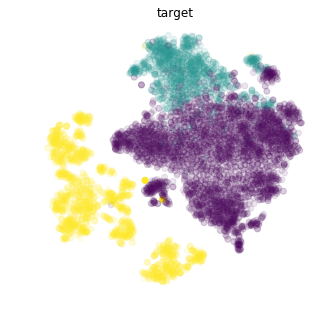

In [15]:
for n in range(2, 6):
    clustering = AgglomerativeClustering(n_clusters=n).fit(X_scaled)
    

    for j in range(n):
        print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
    
    print()
    plt.figure(figsize=(5,5))
    plt.title(col)
    colors = np.array([plt.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in clustering.labels_])
    
    alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
    # setting the alpha channel by replacing the default of the colormap which is 1
    colors[:,3] = alpha
        
    plt.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
                color=colors);
    plt.axis('off')
    plt.show()

**Figure 5:** These figures show Agglomerative clustering of 83 dimensional feature space with 2, 3, 4, and 5 clusters. There is one outlier for the two and three cluster cases. For three and four cluster cases, there are two outliers for each.

## let's take a look at outliers: in the AgglomerativeClustering (n_cluster=2) there is one outlier**

## Extra Credit 1: If you have clusters where you have single object in a cluster (e.g. in my Agglomerative Cluastering with n_cluster=2) try and figure out how why the object that is an outlier and isolated by your clustering model. 

I plotted all objects of the same type as the outlier in the 3-clusters result, but this was not very insightful. Can you do better?

## TASK II.4 what happens if I change the distance metric?

Create a new metric: precompute the braycurtis metric with scipy.spatial.distance.cdist and pass it to the accolmerative clustering with n_clusters=3 and affinity='precomputed'. Describe the result. Look online, on the documentation of scipy and on the any statistical resources (wikipedia has great pages on this) to describe the braycurtis distance.

**Deliverable: make a plot of the t-SNE projection colorcoded by the cluster obtained with the precomputed braycurtis distance and comment on whether it is consistent with the Eucledian distance clustering result.**

In [16]:
from scipy.spatial.distance import cdist

In [17]:
dist = cdist(X_scaled,X_scaled, metric='braycurtis')
clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', 
                                    linkage="complete").fit(dist)
for j in range(2, -1, -1):
        print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))


elements in cluster 2 1489
elements in cluster 1 3737
elements in cluster 0 2622


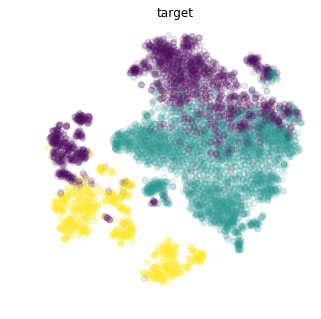

In [18]:
plt.figure(figsize=(5,5))
plt.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([plt.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in clustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
plt.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
plt.axis('off')
plt.show()

**Figure 6:** It shows the Agglomerative clustering of 83 dimensional feature space with braycurtis distance into 3 clusters. The left bottom cluster is well seperated from the other two which is constisten with Figure 5 that are 3, 4, 5 clusters cases. There is also some overlap of the other two clusters.

## Extra Credit II : Also cluster the original, not scaled features but use the Mahalanobis distance, which takes into account the variance of a feature and comment on the result. Is it consistent with the result using Eucledian distance on the scaled feature space

elements in cluster 2 1
elements in cluster 1 1
elements in cluster 0 7846


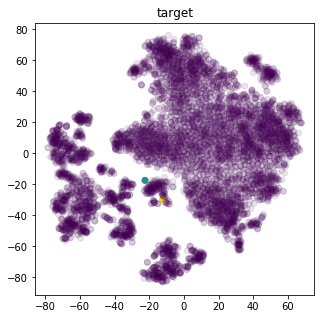

In [19]:
dist = cdist(X,X, metric='mahalanobis')
clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', 
                                    linkage="complete").fit(dist)
for j in range(2, -1, -1):
        print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))

plt.figure(figsize=(5,5))
plt.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([plt.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in clustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
plt.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
#plt.axis('off')
plt.show()

**Figure 7:** It shows the clustering of 83 dimensional space based on Agglomerative clustering with mahalanobis distance on the unscaled features. It's not consistent with the previous plots using Euclidean distance. It only capture 1 cluster and 2 outliers.

## Extra Credit III: What happens if you change clustering strategy?
Cluster the features with DBScan. DBScan is the most cited clustering method. It is density based clustering: it allows you to specify a distance metric, and a minimum distance and number of neightbours within that distance for a point to be considered part of a cluster. Choose and justify your choice on the following parameters 
- eps: the maximum distance between two observations to be in the same cluster
- min_sample: the minimum number of neighbours a cluster needs to have to be a cluster (and not an outlier)



elements in cluster 2 0
elements in cluster 1 3178
elements in cluster 0 1699


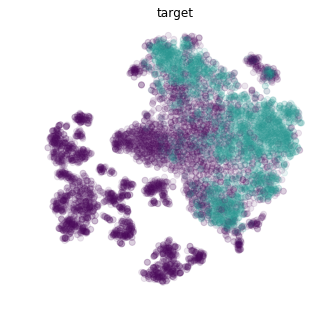

In [20]:
#dist = cdist(X_scaled, X_scaled, 'braycurtis')
DBclustering = sklearn.cluster.DBSCAN(eps=4, min_samples=20, metric='euclidean', 
                       metric_params=None, algorithm='auto', leaf_size=30).fit(X_scaled)

for j in range(2, -1, -1):
        print("elements in cluster {} {}".format(j, (DBclustering.labels_ == j).sum()))

plt.figure(figsize=(5,5))
plt.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([plt.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in DBclustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (DBclustering.labels_ == j).sum() > 200 else 1.0 for j in DBclustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
plt.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
plt.axis('off')
plt.show()

**Figure 8.** It shows the clustering of 83 dimensional space based on DBScan clustering with Euclidean distance into different clusters.  I tested eps =1,2,3,4,5 and I picked eps=4 to balance the number of clusters and the smallest distance for each points. The minimum number of neighbors were estimated from the sparse points on the left bottom.

# what have we learned?...
This was actually very helpful to understand that there are 2 surveys which split into 2 cluster under most cluster parameter choices. Other than that... I am not sure. And this happens a lot to me with clustering to be frank. 
- In many cases above (e.g. AgglomerativeClustering(n_clusters=3).fit(X_scaled) ) the clustring reflected a split that was obvious in the t-SNE visualization of the feature space: a large cluster on the top right of my plot, a more diffuse and structured cluster in the bottom left. This splits the deep drilling fields observations from the regular survey observations. It is good and it makes sense that we get that split, but it is not particularly insightful scientifically cause it tells us about the kind of observations we did, not the nature of the objects.

- In some cases clusters of one (in the Agglomarative clustering) or outliers are identified (DBscan) but in a 79-dimensioanl parameter space it is hard to see what that really means... why is a "outlier" different? In fact this challenge was purposefully designed to have no outliers in the training set (which is what we used) and have outliers in the test set. So our "outliers" should not be outliers. And if we change the parameters in the DBscan they are clustering changes indeed!




# PARTH IIB: Classifying:
Unlike clustering, classifying requires the existance of examples - we are learning by example how to split obervations among classes. We already prepared the train and test samples. 

Notice that tree methods do not require scaling or whitening! Why? because they deal with each feature one by one, so they make no assumption about covariance of features (until you try to do feature importance) **you can use the original X for the tree-based classification**

# TASK II.4 We will treat the 2 surveys separately: the general survey, and the deep drilling fields. 

split the sample into DDF and normal and split each of those into training and test set

**Deliverable: 2 training and 2 test sets, one for DDF and one for the normal survey**



In [21]:
print("breakdown between surveys {} {}".format(
    (metadata.ddf == 1).sum(), (metadata.ddf == 0).sum()))

breakdown between surveys 2116 5732


In [22]:
X = allfeatures.iloc[:,:-1].values
y = allfeatures.iloc[:,-1].values

Xddf = X[allfeatures.ddf == 1]
Xnormal = X[allfeatures.ddf == 0]
yddf =  y[allfeatures.ddf == 1]
ynormal =  y[allfeatures.ddf == 0]



then split training and test set

In [23]:
import sklearn
from sklearn.model_selection import train_test_split

X_trainddf, X_testddf, y_trainddf, y_testddf = train_test_split(
    Xddf, yddf,test_size = 0.4,random_state = 10)

X_trainnormal, X_testnormal, y_trainnormal, y_testnormal = train_test_split(
    Xnormal,ynormal,test_size=0.4,random_state = 10)


## TASK II.5 Classification with Random Forest 
 Below I will use  RandomForest  to classify objects predicting "target" according to the "target" variable of the in the mtadata dataframe for both DDF and normal survey. 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
**Deliverable: comment on the score: what does the number I obtained mean?**


In [24]:
from sklearn.ensemble import RandomForestClassifier

clfddf = RandomForestClassifier(n_estimators=100, 
                        criterion='gini',max_depth=5).fit(X_trainddf, y_trainddf)
clfnormal = RandomForestClassifier(n_estimators=100, 
                        criterion='gini', max_depth=5).fit(X_trainnormal, y_trainnormal)



## measuring the classification performance by using the test score
**Deliverable: comment on the score: what does the number I obtained mean?**

In [25]:
print("Random Forest Classification\n" + 
       "score on DDF {:.2f} and on normal survey {:.2f}".format(
           clfddf.score(X_testddf, y_testddf),
           clfnormal.score(X_testnormal, y_testnormal)))


Random Forest Classification
score on DDF 0.73 and on normal survey 0.64


Comment on what the numbers above mean...:

Score is the mean accuray on test data and labels that were correctly predicted. The number for DDF is larger than the normal survey.

## TASK II.6 Use GradientBoosted trees to redo the same classification 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

**Deliverable: the score obtained solving the classification problem with the GBT model and a comparison of the score obtained with the RF**

In [26]:
# TASK II.6 Use GradientBoosted trees to redo the same classification¶
from sklearn.ensemble import GradientBoostingClassifier

clfddf_gbt = GradientBoostingClassifier(n_estimators=100, max_depth=5).fit(X_trainddf, y_trainddf)
clfnormal_gbt = GradientBoostingClassifier(n_estimators=100,max_depth=5).fit(X_trainnormal, y_trainnormal)

In [27]:

print("Gradient Boosted Trees Classification\n" + 
       "score on DDF {:.2f} and on normal survey {:.2f}".format(
           clfddf_gbt.score(X_testddf, y_testddf),
           clfnormal_gbt.score(X_testnormal, y_testnormal)))

Gradient Boosted Trees Classification
score on DDF 0.79 and on normal survey 0.72


# Because this is a classification problem, we can build a confusion matrix

Confusion matrix, without normalization
Normalized confusion matrix


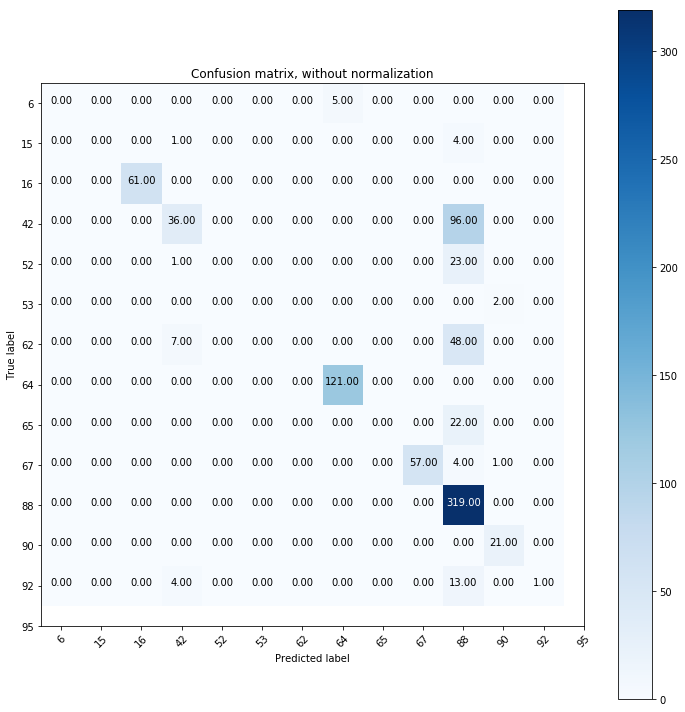

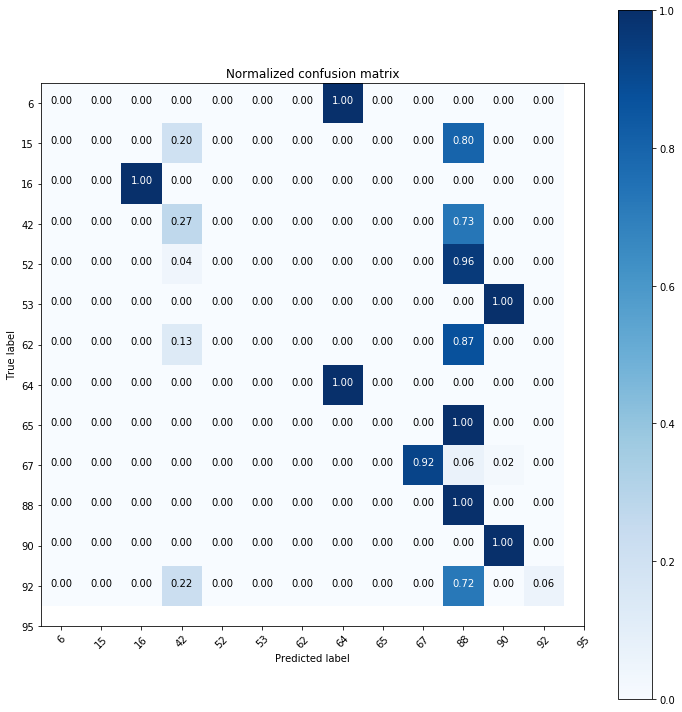

In [28]:
#https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_testddf, clfddf.predict(X_testddf))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()



**Figure 9.** It shows the Normalized and non-normalized comfusion matrices for test data of DDF data. The values mean the percentage of the the data that were correctly labelled.

Confusion matrix, without normalization
Normalized confusion matrix


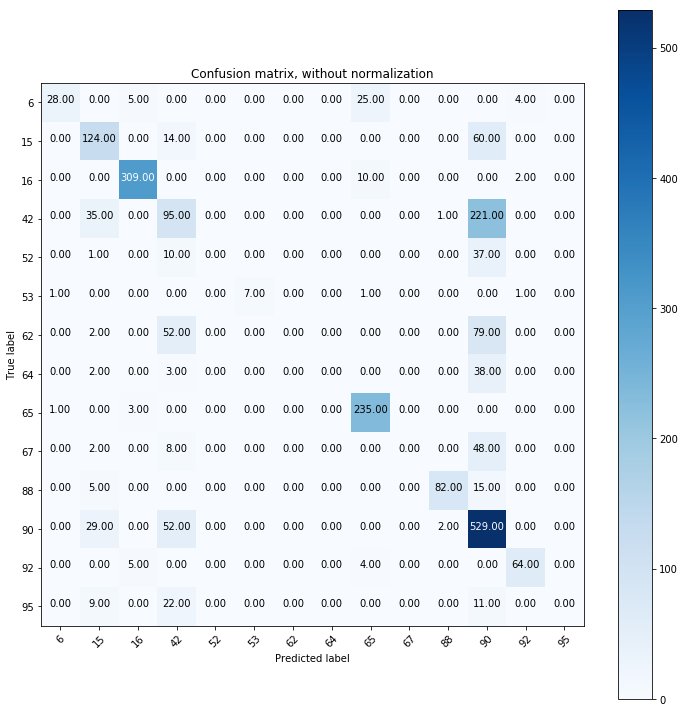

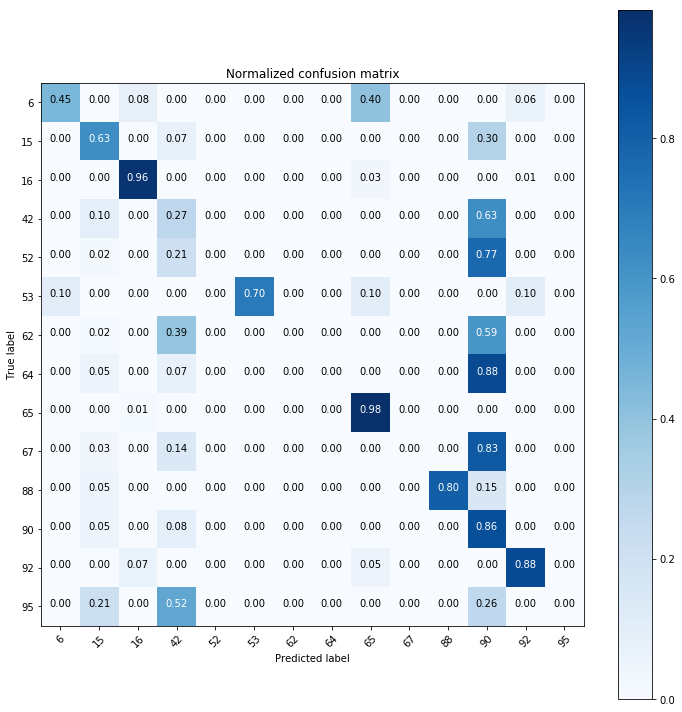

In [29]:
cnf_matrix = sklearn.metrics.confusion_matrix(y_testnormal, clfnormal.predict(X_testnormal))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()



**Figure 10.** It shows the Normalized and non-normalized comfusion matrices for test data of normal data. The values mean the percentage of the the data that were correctly labelled.

# TASK II.7 take a stab at interpreting this. We will discuss in class how to read this properly on tuesday

 It tells us the goodness of our classification. The values are the percentage of correctly classified elements.

# Extra Credit IV: build a confusion matrix for yout gradient boosted tree model and comment on the result